## Research Paper 1, Experiment 1
### Univariate Time Series forecating using variation of LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf

from LSTM_CIFG import LSTM_CIFG
from LSTM_NFG import LSTM_NFG
from LSTM_NIA import LSTM_NIA
from LSTM_NIG import LSTM_NIG
from LSTM_NOA import LSTM_NOA
from LSTM_NOG import LSTM_NOG
from tensorflow.keras.layers import *
from LSTM_PeepHole import PeepholeLSTMCell

from tensorflow.keras.models import Sequential

#from tf.tfa.rnn import PeepholeLSTMCell as LSTM_Peephole

!pip install sktime
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 12.9 MB/s eta 0:00:00


In [8]:
#df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')
df = pd.read_csv('energydata_complete.csv')

<Axes: xlabel='date'>

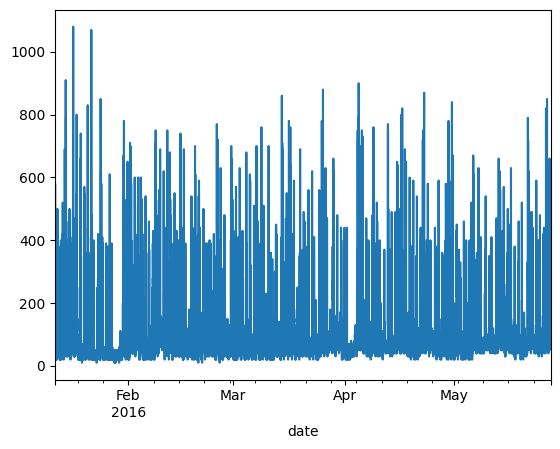

In [9]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.set_index('date')['Appliances'].plot()

In [10]:
df.shape, df.columns

((19735, 29),
 Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
        'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
        'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
        'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
       dtype='object'))

In [11]:
columns = ['Appliances']

In [12]:
train_df = df[columns].iloc[0:13814,:]
val_df = df[columns].iloc[13814:16774,:]
test_df = df[columns].iloc[16774:,:]

In [13]:
num_features  = len(columns)
input_width = 24
label_width = 1
OUT_STEPS = 1
shift = 1

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['Appliances']

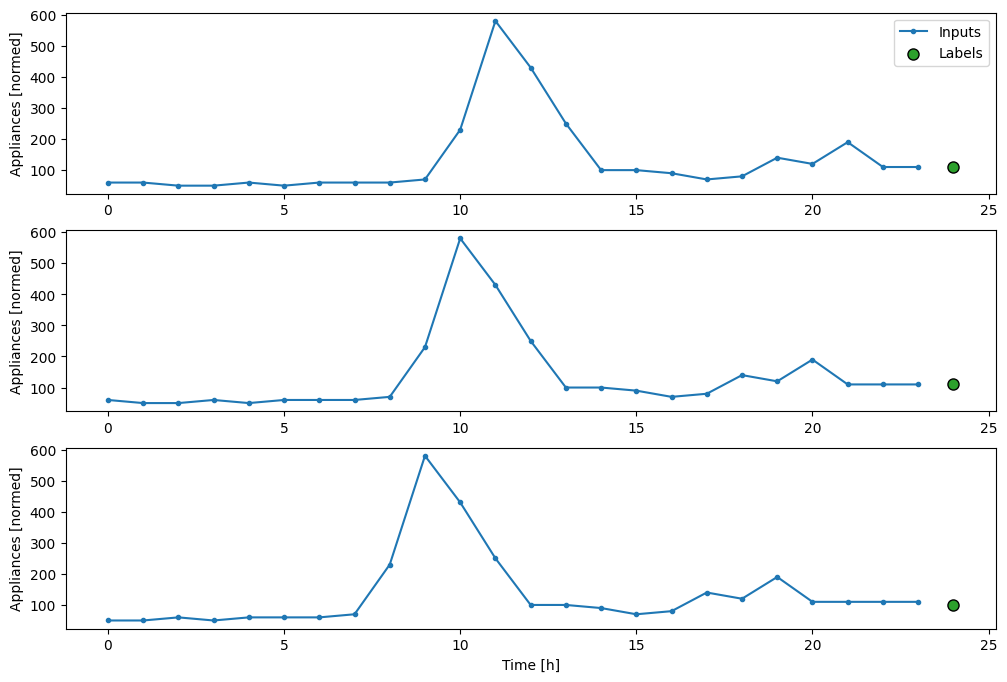

In [14]:
from WindowGenerator import WindowGenerator

single_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=1,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_columns=['Appliances'])

single_window.plot()
single_window

In [55]:
train_performance = {}
val_performance = {}
test_performance = {}
result_df = pd.DataFrame()
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping], verbose=0)
  return history

def evaluate_model(predictions, actuals,y_train):
  '''
  predictions: 1d array
  actuals: 1d array
  y_train: training values for evaluating naive forecast
  '''
  if(len(predictions)!=len(actuals)):
    return "Error: lenght of predition and actuals not equal"
  rmse = np.sqrt(np.average((predictions-actuals)**2))
  mae  = np.average(abs(predictions-actuals))
  #mape  = np.average(abs((predictions-actuals)/actuals))
  mase = mean_absolute_scaled_error(actuals, predictions, y_train=y_train)
  evaluation = {}

  evaluation['rmse'] = rmse
  evaluation['mae']= mae
  #evaluation['mape']= mape
  evaluation['mase'] = mase
  return evaluation

## Model 1: Base LSTM




In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(8,'relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(model, single_window)

#IPython.display.clear_output()

# Result for Train Data
predictions = model.predict(single_window.train).ravel()
actuals     = train_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Val Data
predictions = model.predict(single_window.val).ravel()
actuals     = val_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Test Data
predictions = model.predict(single_window.test).ravel()
actuals     = test_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

result_df



92/92 [==============================] - 1s 8ms/step


,rmse,mae,mase
0,67.711718,31.009129,1.003442
1,57.970335,25.856744,0.836713
2,61.255917,27.270900,0.882474


## LSTM_ PeepHole

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.RNN(PeepholeLSTMCell(64), return_sequences=False),
    tf.keras.layers.Dense(8,'relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(model, single_window)


# Result for Train Data
predictions = model.predict(single_window.train).ravel()
actuals     = train_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Val Data
predictions = model.predict(single_window.val).ravel()
actuals     = val_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Test Data
predictions = model.predict(single_window.test).ravel()
actuals     = test_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

result_df


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


92/92 [==============================] - 1s 9ms/step


,rmse,mae,mase
0,67.711718,31.009129,1.003442
1,57.970335,25.856744,0.836713
2,61.255917,27.270900,0.882474
3,68.452772,31.600908,1.022591
4,58.494407,26.256079,0.849635
5,62.116351,27.631806,0.894153


## LSTM_CIFG

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.RNN(LSTM_CIFG(64), return_sequences=False),
    tf.keras.layers.Dense(8,'relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(model, single_window)

## Evaluate model

# Result for Train Data
predictions = model.predict(single_window.train).ravel()
actuals     = train_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Val Data
predictions = model.predict(single_window.val).ravel()
actuals     = val_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Test Data
predictions = model.predict(single_window.test).ravel()
actuals     = test_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

result_df

built
92/92 [==============================] - 1s 8ms/step


,rmse,mae,mase
0,67.711718,31.009129,1.003442
1,57.970335,25.856744,0.836713
2,61.255917,27.270900,0.882474
3,68.452772,31.600908,1.022591
4,58.494407,26.256079,0.849635
5,62.116351,27.631806,0.894153
6,68.749991,32.250260,1.043604
7,58.909610,26.573571,0.859909
8,62.016310,27.977306,0.905333


## LSTM_NFG

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.RNN(LSTM_NFG(64), return_sequences=False),
    tf.keras.layers.Dense(8,'relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(model, single_window)

## Evaluate model

# Result for Train Data
predictions = model.predict(single_window.train).ravel()
actuals     = train_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Val Data
predictions = model.predict(single_window.val).ravel()
actuals     = val_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Test Data
predictions = model.predict(single_window.test).ravel()
actuals     = test_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

result_df

built
92/92 [==============================] - 1s 8ms/step


,rmse,mae,mase
0,67.711718,31.009129,1.003442
1,57.970335,25.856744,0.836713
2,61.255917,27.270900,0.882474
3,68.452772,31.600908,1.022591
4,58.494407,26.256079,0.849635
5,62.116351,27.631806,0.894153
6,68.749991,32.250260,1.043604
7,58.909610,26.573571,0.859909
8,62.016310,27.977306,0.905333
9,66.666477,31.222548,1.010348


## LSTM_NIA

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.RNN(LSTM_NIA(64), return_sequences=False),
    tf.keras.layers.Dense(8,'relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(model, single_window)

## Evaluate model

# Result for Train Data
predictions = model.predict(single_window.train).ravel()
actuals     = train_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Val Data
predictions = model.predict(single_window.val).ravel()
actuals     = val_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Test Data
predictions = model.predict(single_window.test).ravel()
actuals     = test_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

result_df

## LSTM_NIG

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.RNN(LSTM_NIG(64), return_sequences=False),
    tf.keras.layers.Dense(8,'relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(model, single_window)

## Evaluate model

# Result for Train Data
predictions = model.predict(single_window.train).ravel()
actuals     = train_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Val Data
predictions = model.predict(single_window.val).ravel()
actuals     = val_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Test Data
predictions = model.predict(single_window.test).ravel()
actuals     = test_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

result_df

## LSTM_NOA

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.RNN(LSTM_NOA(64), return_sequences=False),
    tf.keras.layers.Dense(8,'relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(model, single_window)

## Evaluate model

# Result for Train Data
predictions = model.predict(single_window.train).ravel()
actuals     = train_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Val Data
predictions = model.predict(single_window.val).ravel()
actuals     = val_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Test Data
predictions = model.predict(single_window.test).ravel()
actuals     = test_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

result_df

## LSTM_NOG

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.RNN(LSTM_NOG(64), return_sequences=False),
    tf.keras.layers.Dense(8,'relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(model, single_window)

## Evaluate model

# Result for Train Data
predictions = model.predict(single_window.train).ravel()
actuals     = train_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Val Data
predictions = model.predict(single_window.val).ravel()
actuals     = val_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Test Data
predictions = model.predict(single_window.test).ravel()
actuals     = test_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

result_df

## GRU

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(64, return_sequences=False),
    tf.keras.layers.Dense(8,'relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(model, single_window)

## Evaluate model

# Result for Train Data
predictions = model.predict(single_window.train).ravel()
actuals     = train_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Val Data
predictions = model.predict(single_window.val).ravel()
actuals     = val_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

# Result for Test Data
predictions = model.predict(single_window.test).ravel()
actuals     = test_df['Appliances'][24:].values
evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)

result_df

## All Model

In [25]:
#model  = ['LSTM', 'LSTMP', 'GRU', 'CIFG', 'NFG', 'NIA', 'NIG', 'NOA', 'NOG', 'PeepholeLSTMCell']

models = [LSTM, GRU, LSTM_CIFG, LSTM_NFG, LSTM_NIA, LSTM_NIG, LSTM_NOA, LSTM_NOG,PeepholeLSTMCell ]
models_name = np.array(['LSTM', 'GRU', 'CIFG', 'NFG', 'NIA', 'NIG', 'NOA', 'NOG','PeepholeLSTMCell' ])
dataset_name = ['Train', 'Val', 'Test']

In [57]:
def create_compile_fit_model(layer_name,  window, patience=2):
  if layer_name==LSTM:
    layer_name = tf.keras.layers.LSTM(64, return_sequences=False)  
  elif layer_name==GRU:
    layer_name =  tf.keras.layers.GRU(64, return_sequences=False)
  else:
    layer_name = tf.keras.layers.RNN(layer_name(64), return_sequences=False)
  
  model = tf.keras.Sequential([
    layer_name,
    tf.keras.layers.Dense(8,'relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping], verbose=0)
  return history,model




def evaluate_all_model(models, window, y_train):
  
  result_df =pd.DataFrame(columns = ['rmse','mae','mase'])
  ind = []

  for model_name,model in models.items():
    predictions = model.predict(window.train).ravel()
    actuals     = train_df['Appliances'][24:].values
    evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
    result_df   = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)
    ind.append(model_name)

    # Result for Val Data
    predictions = model.predict(window.val).ravel()
    actuals     = val_df['Appliances'][24:].values
    evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
    result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)
    ind.append(model_name)

    # Result for Test Data
    predictions = model.predict(window.test).ravel()
    actuals     = test_df['Appliances'][24:].values
    evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
    result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)
    ind.append(model_name)

    
  
  return result_df,ind


In [27]:
%%time

np.random.seed(16)
tf.random.set_seed(16)
models_all = {}
history_all = {}
for model, model_name in zip(models, models_name):
  history,model = create_compile_fit_model(model,single_window)
  models_all[model_name] = model
  history_all[model_name] = history

built
built
built








built
built
built


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


CPU times: user 42min 41s, sys: 1min 20s, total: 44min 2s
Wall time: 36min 18s


In [ ]:
%%time
result_df,ind = evaluate_all_model(models_all, single_window, train_df['Appliances'].values)
result_df.index = ind
result_df

In [ ]:
results_rmse = []
results_mape = []
results_mase = []

for key,model  in models_all.items():

  # RMSE
  results_rmse.append((model.evaluate(single_window.train)[1]/train_df.shape[0])*1000)
  results_rmse.append((model.evaluate(single_window.val)[1]/val_df.shape[0])*1000)
  results_rmse.append((model.evaluate(single_window.test)[1]/test_df.shape[0])*1000)

  #MAPE
  train_results = pd.DataFrame(data={'Train Predictions':model.predict(single_window.train).ravel(), 'Actuals':train_df['Appliances'][24:].values})
  val_results = pd.DataFrame(data={'Val Predictions':model.predict(single_window.val).ravel(), 'Actuals':val_df['Appliances'][24:].values})
  test_results = pd.DataFrame(data={'Test Predictions':model.predict(single_window.test).ravel(), 'Actuals':test_df['Appliances'][24:].values})
  mape = tf.keras.losses.MeanAbsolutePercentageError()
  #mape(train_results['Train Predictions'], train_results['Actuals']).numpy()
  results_mape.append(mape(train_results['Train Predictions'], train_results['Actuals']).numpy())
  results_mape.append(mape(val_results['Val Predictions'], val_results['Actuals']).numpy())
  results_mape.append(mape(test_results['Test Predictions'], test_results['Actuals']).numpy())

  #MASE
  results_mase.append(mean_absolute_scaled_error(train_df['Appliances'][24:].values, model.predict(single_window.train).ravel(), y_train=train_df['Appliances'].values))
  results_mase.append(mean_absolute_scaled_error(val_df['Appliances'][24:].values, model.predict(single_window.val).ravel(), y_train=train_df['Appliances'].values))
  results_mase.append(mean_absolute_scaled_error(test_df['Appliances'][24:].values, model.predict(single_window.test).ravel(), y_train=train_df['Appliances'].values))

  #results_mase.append(mean_absolute_scaled_error(y_train1, model.predict(X_train1), y_train=y_train1))
  #results_mase.append(mean_absolute_scaled_error(y_val1, model.predict(X_val1), y_train=y_val1))
  #results_mase.append(mean_absolute_scaled_error(y_test1, model.predict(X_test1), y_train=y_test1))

In [45]:
len(results_mape)

0

In [46]:
id= 0
ind = []
for i in models_name:
  for j in range(3):
    ind.append(i)
    #result_df.iloc[id,0] = i
    id=id+1


result_df = pd.DataFrame(data={'Model Name':ind, 'RMSE': results_rmse,
                               'MASE': results_mase,'MAPE': results_mape})
#result_df.rename(columns = {'RMSE':'Model'}, inplace=True)

result_df['RMSE'] = results_rmse
result_df['MAPE'] = results_mape
result_df['MASE'] = results_mase
result_df.round(decimals=3)

ValueError: ignored

In [30]:
result_df[0::3].sort_values(['RMSE'])

,Model Name,RMSE,MASE
24,PeepholeLSTMCell,4.833216,0.976959
15,NIG,4.897663,1.023708
3,GRU,4.906745,1.000562
6,CIFG,4.907419,1.018844
0,LSTM,4.931156,1.021181
12,NIA,4.933763,1.011290
18,NOA,4.971135,0.945996
9,NFG,4.992595,1.010035
21,NOG,5.015547,1.039848


In [31]:
result_df[1::3].sort_values(['RMSE'])

,Model Name,RMSE,MASE
25,PeepholeLSTMCell,19.404275,0.820242
16,NIG,19.669535,0.856304
7,CIFG,19.708017,0.849406
1,LSTM,19.734251,0.852372
13,NIA,19.754126,0.837980
4,GRU,19.774566,0.842198
10,NFG,19.936845,0.841016
19,NOA,19.990335,0.787701
22,NOG,20.116561,0.867028


In [32]:
result_df[2::3].sort_values(['RMSE'])

,Model Name,RMSE,MASE
26,PeepholeLSTMCell,20.424973,0.859833
20,NOA,20.488497,0.817404
17,NIG,20.656838,0.894129
5,GRU,20.792967,0.873039
8,CIFG,20.813348,0.885396
14,NIA,20.846518,0.871416
2,LSTM,20.855094,0.898525
11,NFG,20.965060,0.875449
23,NOG,21.038416,0.895400


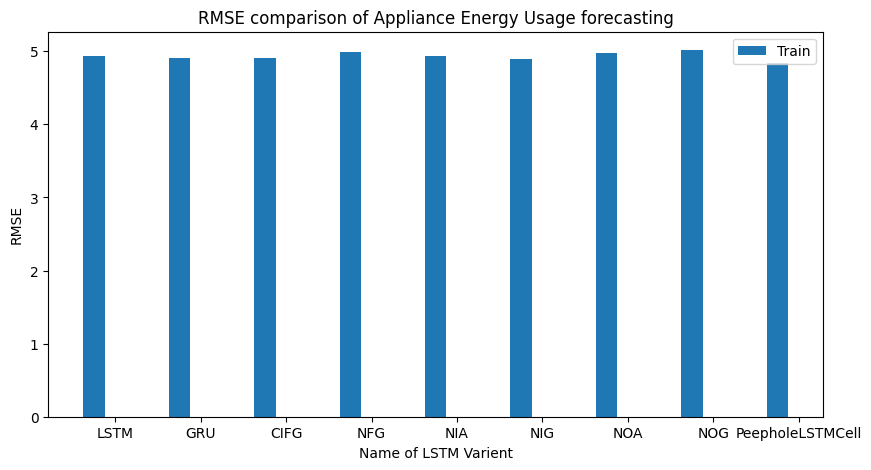

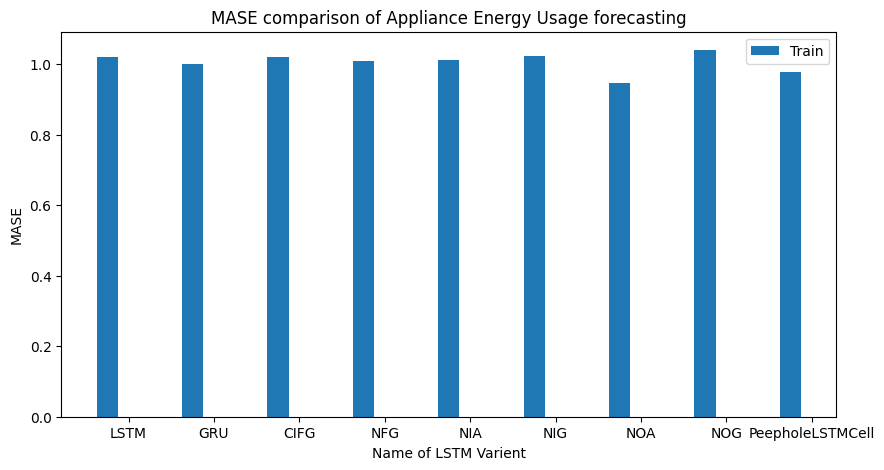

In [33]:
barWidth = 0.25

models_n1 = np.arange(len(models))
models_n2 = [x + barWidth for x in models_n1]
models_n3 = [x + barWidth for x in models_n2]

eval_matrix = {"RMSE":result_df['RMSE'], "MASE":result_df['MASE']}

for key, m in eval_matrix.items():
  values1 = list(m[0::3].values.reshape(1,-1))
  values2 = list(m[1::3].values.reshape(1,-1))
  values3 = list(m[2::3].values.reshape(1,-1))

  # creating the bar plot
  fig = plt.figure(figsize = (10, 5))
  plt.bar(models_n1, values1[0], width=0.25, )
  plt.bar(models_n2, values2[0], width=0.25, )
  plt.bar(models_n3, values3[0], width=0.25, )

  plt.xticks([r + barWidth for r in range(len(models))],models_name)
  plt.legend(dataset_name)
  plt.xlabel("Name of LSTM Varient")
  plt.ylabel(key)
  plt.title(key+" comparison of Appliance Energy Usage forecasting")
  #plt.savefig(key+'.png', dpi=300)
  plt.show()

Text(0, 0.5, 'Loss: Root Mean Squred Error')

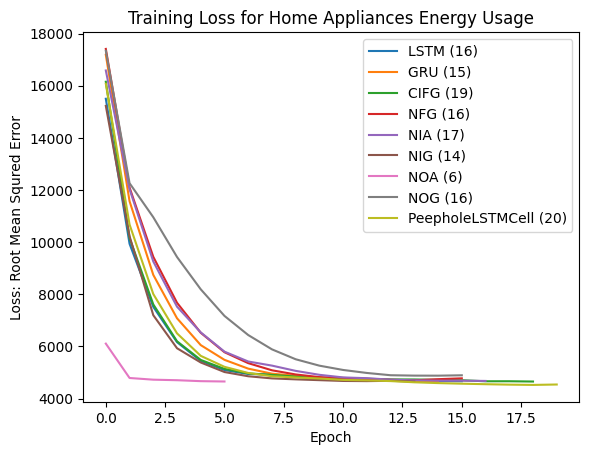

In [38]:
l=[]
for model_name in history_all:
  #print(model_name)
  plt.plot(history_all[model_name].history['loss']) 
  l.append(model_name+" ("+str(len(history_all[model_name].history['loss']))+")")

plt.legend(l)
plt.title("Training Loss for Home Appliances Energy Usage")
plt.xlabel("Epoch")
plt.ylabel("Loss: Root Mean Squred Error")
#plt.savefig("loss.png", dpi=300)
 